In [27]:
# Load SpaGRN and dependencies
import os
import sys

import argparse
import pandas as pd
import scanpy as sc
from multiprocessing import cpu_count

from spagrn.regulatory_network import InferNetwork as irn

In [28]:
data = sc.read_visium("152807")
data

/home/zyy/miniconda3/envs/spagrn/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3403 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [29]:
data.write_h5ad("spagrn_input.h5ad")

In [30]:
fn = 'spagrn_input.h5ad'
data = irn.read_file(fn)
print(data)

AnnData object with n_obs × n_vars = 3403 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/home/zyy/miniconda3/envs/spagrn/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [31]:
data.var_names_make_unique()

In [32]:
data = irn.preprocess(data, min_genes=10, min_cells=3, min_counts=10, max_gene_num=10000)
print(data)

View of AnnData object with n_obs × n_vars = 3403 × 16718
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts'
    uns: 'spatial'
    obsm: 'spatial'


In [33]:
data = irn.preprocess(data, min_genes=10, min_cells=3, min_counts=10, max_gene_num=10000)
print(data)

View of AnnData object with n_obs × n_vars = 3403 × 16718
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts'
    uns: 'spatial'
    obsm: 'spatial'


In [34]:
data.X.max()

622.0

In [35]:
data.layers["counts"] = data.X.copy()

In [36]:
# 检查特定数据层（如"counts"）中的全零基因数量
import numpy as np
print(f"该层全零基因: {np.sum(data.layers['counts'].sum(axis=0)== 0)}")


该层全零基因: 0


/home/zyy/miniconda3/envs/spagrn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


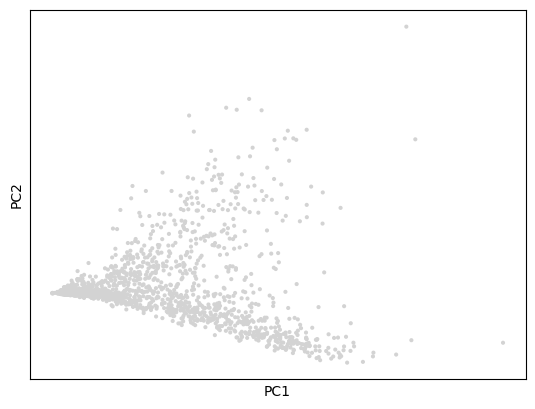

In [37]:
sc.tl.pca(data)
sc.pl.pca(data)

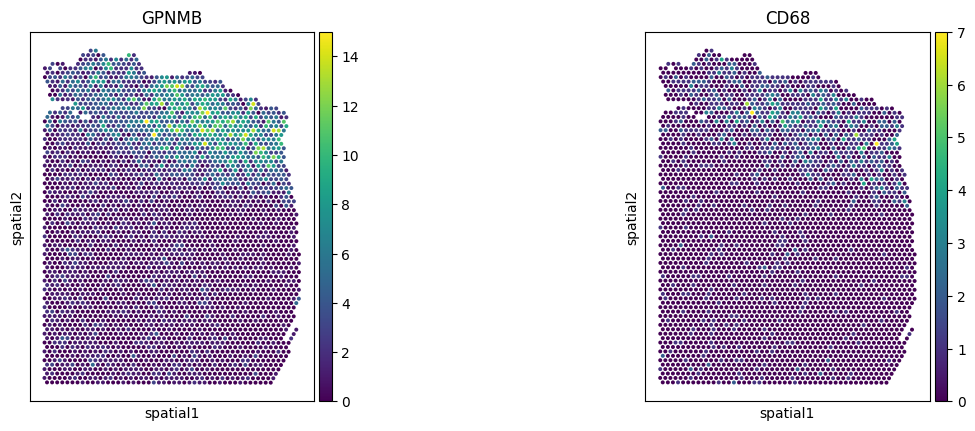

In [39]:
# adata
sc.pl.spatial(data, color=['GPNMB', "CD68"], size=1.2, img_key='hires', scale_factor=1.0)

In [40]:
sc.pp.normalize_total(data)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data,flavor='seurat',n_top_genes=4000,inplace=True)
sc.pp.pca(data,n_comps=50,use_highly_variable=True,svd_solver='arpack')
sc.pp.neighbors(data)

sc.tl.umap(data)
sc.tl.leiden(data,key_added='clusters') # cluster的分群后对面步骤中的转录因子的定义很重要

/home/zyy/miniconda3/envs/spagrn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


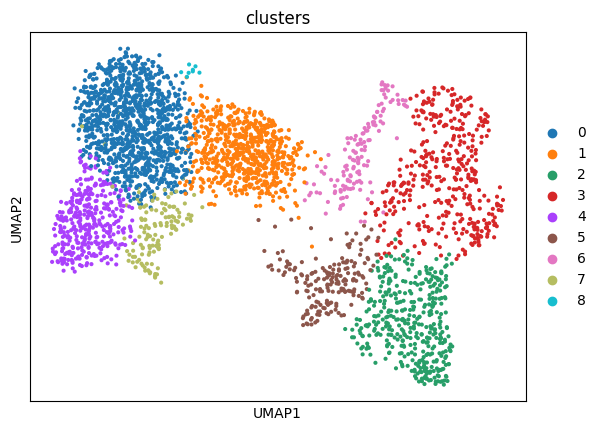

In [41]:
sc.pl.umap(data,color='clusters',palette=sc.pl.palettes.default_20)

In [14]:
# tfs_fn = 'mouse_tfs.txt'
# database_fn = 'mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
# motif_anno_fn = 'motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl'

In [42]:
tfs_fn = 'allTFs_hg38.txt'
database_fn = 'hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather'
motif_anno_fn = 'motifs-v9-nr.hgnc-m0.001-o0.0.tbl'

In [43]:
import pandas as pd
ranking = pd.read_feather("hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather")
print(ranking.head())
print(ranking.columns)  # 会有一列叫 "Gene" 或 "__index__"
# 获取所有包含的基因名称
gene_names = ranking.columns.tolist()

# 检查是否包含
print("MALAT1" in gene_names)         # True or False
print("MTRNR2L12" in gene_names)      # True or False

    A1BG  A1BG-AS1   A1CF    A2M  A2M-AS1  A2ML1  A2MP1  A3GALT2  A4GALT  \
0  23235     26300   5366  15611    25934  15160  15441     5824   11304   
1  25699     26242   8778  13433    25423  20623   4101     7496   13708   
2  23281     26095   8092  15999    26831   9639   4265    14633   17210   
3  25221     25848  10063  13627    23941   2104  13478    12095   14206   
4  25196     26444   8382   9214    25917  15786  13970     5053   11956   

   A4GNT  ...  ZWINT   ZXDA   ZXDB   ZXDC  ZYG11A  ZYG11B    ZYX  ZZEF1  \
0   7906  ...  23910  13617  10914  11570   21644   21918  22389  19593   
1   3125  ...  20254   8545  12284  23121   21073   19529  18079   5421   
2   8098  ...  18260  22419  17114  17348   22387   13110  11666  14500   
3   5370  ...  25564  19977  17695  22205   20183   12391  21932   7726   
4   6455  ...  25906  18441   9162  23161   23356   13383  19326  14897   

    ZZZ3                                             motifs  
0   8730                      

In [44]:
data.layers["log1p"] = data.X.copy()

In [45]:
grn = irn(data)

In [46]:
niche_human = pd.read_csv('lr_network_human.csv')
niche_mouse = pd.read_csv('lr_network_mouse.csv')
# concat the databases together if you are using multiple ligand-receptors databases
niches = pd.concat([niche_mouse, niche_human])
print(niches)

               from      to  database    source
0     2300002M23Rik    Ddr1  omnipath  omnipath
1     2610528A11Rik   Gpr15  omnipath  omnipath
2     9530003J23Rik   Itgal  omnipath  omnipath
3                 a    Atrn  omnipath  omnipath
4                 a    F11r  omnipath  omnipath
...             ...     ...       ...       ...
4981          ZNRF3    FZD4  omnipath  omnipath
4982            ZP3    EGFR  omnipath  omnipath
4983            ZP3  CHRNA7  omnipath  omnipath
4984            ZP3   MERTK  omnipath  omnipath
4985          ZPBP2    CD80  omnipath  omnipath

[10654 rows x 4 columns]


regulatory_network.py 调整改处参数很重要

In [47]:
grn.infer(database_fn,
              motif_anno_fn,
              tfs_fn,
              niche_df=niche_human,
              num_workers=16,
              cache=False,
              save_tmp=True,
              c_threshold=0.1,
              layers="counts",
              latent_obsm_key='spatial',
              model='danb',
              n_neighbors=2, # 降低neighbor！！该参数很重要
              weighted_graph=False,
              cluster_label='clusters',
              method='spg',
              prefix='secretory_mid',
              noweights=False)

AnnData object with n_obs × n_vars = 3403 × 16718
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_counts', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'pca', 'log1p', 'hvg', 'neighbors', 'umap', 'leiden', 'clusters_colors', 'method'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'distances', 'connectivities'
data:	 AnnData object with n_obs × n_vars = 3403 × 16718
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_counts', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'pca', 'log1p', 'hvg', 'neighbors', 'umap', 'leiden', 'clusters_colors', 'method'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'distances', 'connectivities'
latent_ob

/home/zyy/miniconda3/envs/spagrn/lib/python3.8/site-packages/hotspot/hotspot.py:98: UserWarning: Hotspot will work faster when counts are a csc sparse matrix.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 16718/16718 [03:49<00:00, 72.94it/s]


Computing pair-wise local correlation on 954 features...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 454581/454581 [00:33<00:00, 13639.09it/s]

2025-04-09 10:28:45,827 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-04-09 10:28:45,838 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2025-04-09 10:28:46,543 - pyscenic.utils - INFO - Creating modules.


len(modules) 388
rank_threshold 1500
prune_auc_threshold 0.07
nes_threshold 3.0
##########重新设置参数ing###################
[                                        ] | 0% Completed | 164.97 ss


2025-04-09 10:32:04,490 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 287.28 s


2025-04-09 10:34:06,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UQCRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 290.82 s


2025-04-09 10:34:10,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 409.89 s


2025-04-09 10:36:09,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UQCRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 413.44 s


2025-04-09 10:36:12,913 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 428.53 s


2025-04-09 10:36:28,038 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF3A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 443.02 s


2025-04-09 10:36:42,545 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 462.48 s


2025-04-09 10:37:01,978 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 487.51 s


2025-04-09 10:37:27,024 - pyscenic.transform - WARNING - Less than 80% of the genes in YBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 549.11 s


2025-04-09 10:38:28,652 - pyscenic.transform - WARNING - Less than 80% of the genes in LTF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[                                        ] | 0% Completed | 10m 11ss


2025-04-09 10:39:30,615 - pyscenic.transform - WARNING - Less than 80% of the genes in YBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings. Skipping this module.


[########################################] | 100% Completed | 12m 57s
df:                                                        Enrichment            \
                                                              AUC       NES   
TF    MotifID                                                                 
ATOH8 transfac_pro__M07919                               0.022106  3.059085   
      cisbp__M4831                                       0.016484  2.043559   
      flyfactorsurvey__CG17181_SANGER_5_FBgn0035144      0.018519  2.411142   
CEBPD cisbp__M3032                                       0.013034  1.786612   
      swissregulon__hs__CEBPA_B_DDIT3.p2                 0.015007  2.348075   
...                                                           ...       ...   
XBP1  cisbp__M5302                                       0.013484  2.327469   
      transfac_pro__M07678                               0.014394  2.632971   
      transfac_public__M00538                            

In [48]:
adata = sc.read_h5ad('secretory_mid_spagrn.h5ad')
adata

AnnData object with n_obs × n_vars = 3403 × 16718
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_counts', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'adj', 'clusters_colors', 'hvg', 'leiden', 'log1p', 'method', 'neighbors', 'pca', 'receptor_dict_all', 'receptors_all', 'regulon_dict', 'rss', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'auc_mtx', 'rep_auc_mtx', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

In [49]:
adata.uns['regulon_dict']

{'ATOH8(+)': array(['SERPINA1', 'SLC34A2', 'XBP1', 'ELK4', 'DHRS3', 'TNFSF10',
        'CTNNA2', 'SOX9', 'ACSL5', 'MFHAS1', 'HOMER2', 'SAT1', 'PIGR',
        'PDK4', 'CLU', 'CYP24A1', 'C4BPA', 'IL6ST', 'STC1'], dtype=object),
 'BAD(+)': array(['ADRA2C', 'NDUFS7'], dtype=object),
 'CD59(+)': array(['HOMER2', 'SGK1', 'SAT1', 'PIGR', 'ERRFI1', 'SERPING1', 'LGALS3',
        'CD59', 'C4BPA', 'IL1R1', 'XBP1', 'ACSL5', 'IL6ST', 'NAMPT',
        'STC1'], dtype=object),
 'CEBPD(+)': array(['RCC2', 'EIF1', 'HERPUD1', 'SERPINH1', 'FAM84B', 'SLC34A2', 'ADD3',
        'CD55', 'TNFAIP2', 'EFNA1', 'RAB40B', 'SLC12A7', 'GALNT15',
        'ADCY1', 'FBLN2', 'PAPLN', 'ARRDC3', 'H3F3B', 'RBM47', 'TUBA1C',
        'SCNN1A', 'GJA1', 'PIK3R1', 'P2RY14', 'UBALD2', 'MDK', 'HELZ',
        'PERP', 'PROSER2', 'ANXA4', 'ERRFI1', 'HNRNPH1', 'SOX4', 'BASP1',
        'SEMA5A', 'ID4', 'WNT2', 'ATP1A1', 'MME', 'ANXA2', 'LGALS3',
        'GABARAPL1', 'ST6GAL1', 'HAND2', 'S100A11', 'ICA1', 'DHRS3',
        'AGPAT5', 'CTS

In [50]:
adata.uns['receptors_all']

array(['CD36', 'CD248', 'PTGER3', 'FXYD1', 'ADGRE5', 'CD99', 'ST14',
       'SLC40A1', 'LRP1', 'ALCAM', 'CLDN5', 'IL1R1', 'CLDN7', 'CLDN3',
       'RAMP1', 'GNAS', 'THY1', 'MCAM', 'CSPG4', 'PTK7', 'DDR1', 'INSR',
       'F3', 'EZR', 'FCGRT', 'EPCAM', 'FXYD6', 'SDC1', 'CRLF1', 'CD55',
       'BDKRB2', 'PLAT', 'C1R', 'PDGFRB', 'CXCR4', 'MET', 'ECE1', 'LIFR',
       'ERBB3', 'CD151', 'CD74', 'ACKR1', 'MMP2', 'ADCY1', 'ADRA2C',
       'GPR161', 'RXFP1', 'CDH1', 'TSPAN1', 'LRPAP1', 'MPZL2', 'IL20RA',
       'ANXA2', 'IL6ST', 'PDGFRA', 'MUC1', 'F11R', 'AQP1', 'MYLK', 'RPSA',
       'CLDN4', 'TNFRSF21', 'P2RY14', 'PIGR', 'CD81', 'TMEM123', 'AVPR1A',
       'STRA6', 'ITGB8', 'APCDD1', 'EDNRB', 'CDH11'], dtype=object)

In [53]:
adata.obsm['auc_mtx']

,ATOH8(+),BAD(+),CD59(+),CEBPD(+),DLX5(+),ELF3(+),ELK4(+),ENO1(+),ETFB(+),ETS2(+),...,SOX9(+),TAGLN2(+),TCF12(+),TCF23(+),TGIF1(+),TRAF4(+),TWIST2(+),UQCRB(+),XBP1(+),ZNF600(+)
Cell,,,,,,,,,,,,,,,,,,,,,
AAACACCAATAACTGC-1,0.181029,0.567845,0.294734,0.387187,0.315204,0.347115,0.321212,0.273863,0.870465,0.333135,...,0.280764,0.395647,0.468700,0.670231,0.319698,0.460757,0.433603,0.177657,0.347861,0.130861
AAACAGCTTTCAGAAG-1,0.275339,0.823195,0.353534,0.431288,0.349363,0.307148,0.339059,0.309288,0.616385,0.342505,...,0.277552,0.250376,0.514464,0.712332,0.313487,0.309138,0.473894,0.543265,0.375170,0.116396
AAACAGGGTCTATATT-1,0.384573,0.301962,0.676792,0.456670,0.410977,0.355908,0.372188,0.351579,0.953765,0.401777,...,0.398544,0.409223,0.536811,0.751671,0.487964,0.568984,0.497403,0.969298,0.393771,0.108488
AAACAGTGTTCCTGGG-1,0.365154,0.290521,0.498692,0.439579,0.284625,0.311792,0.336059,0.370952,0.610237,0.368754,...,0.269744,0.251761,0.538308,0.789732,0.368469,0.189736,0.479205,0.705057,0.384474,0.111786
AAACATGGTGAGAGGA-1,0.387262,0.778297,0.471037,0.454665,0.378592,0.435983,0.365203,0.466914,0.515346,0.405363,...,0.345381,0.412965,0.552089,0.803115,0.365635,0.413974,0.495510,0.954816,0.400316,0.330109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.621112,0.948447,0.860236,0.691953,0.714310,0.592290,0.657618,0.556934,0.475140,0.680755,...,0.636287,0.665641,0.705314,0.508591,0.700228,0.606312,0.707523,0.667408,0.666321,0.727069
TTGTTTCACATCCAGG-1,0.249823,0.000000,0.272293,0.408459,0.318940,0.257793,0.340398,0.302461,0.421958,0.340345,...,0.242299,0.274972,0.493779,0.589505,0.262410,0.226845,0.473815,0.730571,0.350850,0.144939
TTGTTTCATTAGTCTA-1,0.209009,0.836990,0.308505,0.403537,0.256164,0.267354,0.306818,0.257817,0.402012,0.328306,...,0.251851,0.292542,0.490460,0.786446,0.322168,0.198327,0.437873,0.779826,0.343974,0.297726


In [55]:
import spagrn.plot as prn
%matplotlib inline
prn.plot_2d(adata, adata.obsm['auc_mtx'], pos_label='spatial', reg_name='JUNB', fn='JUNB.pdf')

In [56]:
import spagrn.plot as prn
%matplotlib inline
prn.plot_2d(adata, adata.obsm['auc_mtx'], pos_label='spatial', reg_name='JUND', fn='JUND.pdf')

In [63]:
import spagrn.plot as prn
%matplotlib inline
prn.plot_2d(adata, adata.obsm['auc_mtx'], pos_label='spatial', reg_name='ELK4', fn='ELK4.pdf')

In [68]:
import spagrn.plot as prn
%matplotlib inline
prn.plot_2d(adata, adata.obsm['auc_mtx'], pos_label='spatial', reg_name='SOX4', fn='SOX4.pdf')

In [72]:
import spagrn.plot as prn
%matplotlib inline
prn.plot_2d(adata, adata.obsm['auc_mtx'], pos_label='spatial', reg_name='HOXB5', fn='HOXB5.pdf')

In [76]:
import spagrn.plot as prn
%matplotlib inline
prn.plot_2d(adata, adata.obsm['auc_mtx'], pos_label='spatial', reg_name='FOXO1', fn='FOXO1.pdf')

KeyError: 'FOXO1(+)'

In [41]:
prn.auc_heatmap(data,
                auc_mtx,
                cluster_label='clusters',
                topn=10,
                subset=False,
                save=True,
                fn=f'{out_dir}/{method}_clusters_heatmap_top10.png',
                legend_fn=f"{out_dir}/{method}_rss_celltype_legend_top10.png")


NameError: name 'auc_mtx' is not defined